## IDLS Project

#Effect of Normalization on Image Classification Tasks

## Adaptive Gradient Clipping

According to Brock et.al., there are two main factors affecting the potency of AGD in replacing batch normalization:
1. The clipping threshhold 
2. Batch size

This notebook contains the code for the ablation study for the best values of the two for our application. Here, we take the thresholds for the clipping candidates as [0.01, 0.02, 0.04]. The candidate batch sizes are [64, 128, 256].

ACG is applied to our self-implemented Resnet50 model, and performance is measured on the CIFAR10 dataset. The Resnet50 model is built with no batchnorm layers, and [0,1,2,3] dropout layers with dropout probability of 0.2.

We measure the following metrics:
1. Accuracy after 1 epochs
2. Time taken to complete 1 epochs


References:
1. https://github.com/sayakpaul/Adaptive-Gradient-Clipping
2. https://arxiv.org/abs/2102.06171


## Ablation Tests

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import  Rectangle
import tensorflow as tf

import keras,os
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D,MaxPooling2D, Flatten,BatchNormalization, Dropout,ZeroPadding2D, AveragePooling2D, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import activations
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical

import time

In [ ]:
 #Resnet50 implementation

def res_identity(x, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = 0):
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters
  bn = num_batchnorm
  drp = num_dropout

  #first block 
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob)(x)
    drp-=1

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob)(x)
    drp-=1

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob)(x)
    drp-=1

  # add the input 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)


  return x

def res_conv(x, s, filters, num_batchnorm = 0, num_dropout=0, dropout_prob = 0):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters
  bn = num_batchnorm
  drp = num_dropout

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob)(x)
    drp-=1

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1
  x = Activation(activations.relu)(x)
  if drp>0:
    x = Dropout(dropout_prob)(x)
    drp-=1

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid')(x)
  if bn>0:
    x = BatchNormalization()(x)
    bn-=1

  # shortcut 
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid')(x_skip)
  x_skip = BatchNormalization()(x_skip)

  # add 
  x = Add()([x, x_skip])
  x = Activation(activations.relu)(x)

  return x

def resnet50(num_batchnorm = 0, bn_pooling = False, dropout_prob =0, num_dropout_conv = 0, num_dropout_id = 0, num_dropout=0):

  input_im = Input(shape=(32, 32, 3)) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)
  bn = num_batchnorm
  drp = num_dropout

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
  if bn_pooling:
    x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)
  if drp>0:
    x = Dropout(dropout_prob)(x)
    drp-=1

  #2nd stage 
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(64, 256),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(128, 512),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(256, 1024),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_conv, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)
  x = res_identity(x, filters=(512, 2048),num_batchnorm=bn, num_dropout = num_dropout_id, dropout_prob = dropout_prob)

  # ends with average pooling and dense connection

  x = AveragePooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  if drp>0:
    x = Dropout(dropout_prob)(x)
    drp-=1
  x = Dense(10, activation='softmax')(x) #multi-class

  # define the model 

  model = Model(inputs=input_im, outputs=x, name='Resnet50')

  return model

In [ ]:
# Adaptive Gradient Clipping
def compute_norm(x, axis, keepdims):
    return tf.math.reduce_sum(x ** 2, axis=axis, keepdims=keepdims) ** 0.5

def unitwise_norm(x):
    if len(x.get_shape()) <= 1:  # Scalars and vectors
        axis = None
        keepdims = False
    elif len(x.get_shape()) in [2, 3]:  # Linear layers of shape IO or multihead linear
        axis = 0
        keepdims = True
    elif len(x.get_shape()) == 4:  # Conv kernels of shape HWIO
        axis = [0, 1, 2,]
        keepdims = True
    else:
        raise ValueError(f"Got a parameter with shape not in [1, 2, 4]! {x}")
    return compute_norm(x, axis, keepdims)


def adaptive_clip_grad(parameters, gradients, clip_factor=0.01,
                       eps=1e-3):
    new_grads = []
    for (params, grads) in zip(parameters, gradients):
        p_norm = unitwise_norm(params)
        max_norm = tf.math.maximum(p_norm, eps) * clip_factor
        grad_norm = unitwise_norm(grads)
        clipped_grad = grads * (max_norm / tf.math.maximum(grad_norm, 1e-6))
        new_grad = tf.where(grad_norm < max_norm, grads, clipped_grad)
        new_grads.append(new_grad)
    return new_grads

In [ ]:
#AGC Model
class AGCModel(tf.keras.Model):
    def __init__(self, model, clip_factor=0.01, eps=1e-3):
        super(AGCModel, self).__init__()
        self.resnet = model
        self.clip_factor = clip_factor
        self.eps = eps
    
    def train_step(self, data):
        images, labels = data

        with tf.GradientTape() as tape:
            predictions = self.resnet(images)
            loss = self.compiled_loss(labels, predictions)
        trainable_params = self.resnet.trainable_variables
        gradients = tape.gradient(loss, trainable_params)
        agc_gradients = adaptive_clip_grad(trainable_params, gradients, 
                                               clip_factor=self.clip_factor, eps=self.eps)
        self.optimizer.apply_gradients(zip(agc_gradients, trainable_params))

        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, labels = data
        predictions = self.resnet(images, training=False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}

    def save_weights(self, filepath):
        self.resnet.save_weights(filepath=filepath)

    def call(self, inputs, *args, **kwargs):
        return self.resnet(inputs)

In [ ]:
def fit_agc_resnet(model,xtrain,ytrain,xtest, ytest, batchsize):
  
  EPOCHS = 1      
  BATCH_SIZE= batchsize
  VERBOSITY = 1

  opt = keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=['accuracy'])

  #fit the model
  start = time.time()
  model.fit(xtrain, ytrain, batch_size = BATCH_SIZE, verbose=VERBOSITY ,epochs = EPOCHS)
  train_time = time.time() - start

  #evaluate
  score = model.evaluate(xtest,ytest)
  loss = score[0]
  acc = score[1]

  return train_time,  acc

In [ ]:
#prepare data

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

# Data normalization
x_train = x_train/255
x_test = x_test/255
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)

print(x_train.shape, y_train.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 10)


In [ ]:
num_dropout=[1,2,3]
dropout_probs = [0.2,0.5,0.8]
clip_threshholds = [0.01,0.02,0.04]
batch_sizes = [64,128,256]

In [ ]:
#dropout prob=0.2
data = []

for drp in num_dropout:
  for clip in clip_threshholds:
    for batch in batch_sizes:
      prob =0.2
      print('Training ACG DP{}, DPPROB{}, CLIPFACT{}, BATCHSIZE{}'.format(drp,prob,clip,batch))
      model = AGCModel(resnet50(num_batchnorm=0, bn_pooling=False, num_dropout_conv=drp, num_dropout_id=drp, dropout_prob=prob),clip_factor=clip)
      tt, acc = fit_agc_resnet(model, x_train, y_train, x_test, y_test, batchsize= batch)
      data.append([drp,clip,batch,tt,acc])
      print('Final accuracy {} reached in {} s'.format(acc, tt))

Training ACG DP1, DPPROB0.2, CLIPFACT0.01, BATCHSIZE64
313/313 [==============================] - 8s 23ms/step - loss: 1.7447 - accuracy: 0.3999
Final accuracy 0.39989998936653137 reached in 119.25605058670044 s
Training ACG DP1, DPPROB0.2, CLIPFACT0.01, BATCHSIZE128
313/313 [==============================] - 8s 23ms/step - loss: 1.6668 - accuracy: 0.3889
Final accuracy 0.3889000117778778 reached in 79.38144898414612 s
Training ACG DP1, DPPROB0.2, CLIPFACT0.01, BATCHSIZE256
313/313 [==============================] - 8s 23ms/step - loss: 1.6031 - accuracy: 0.3968
Final accuracy 0.3968000113964081 reached in 54.23606252670288 s
Training ACG DP1, DPPROB0.2, CLIPFACT0.02, BATCHSIZE64
313/313 [==============================] - 8s 22ms/step - loss: 1.5449 - accuracy: 0.4328
Final accuracy 0.4327999949455261 reached in 119.41945266723633 s
Training ACG DP1, DPPROB0.2, CLIPFACT0.02, BATCHSIZE128
313/313 [==============================] - 8s 22ms/step - loss: 1.4725 - accuracy: 0.4559
Final acc

In [ ]:
#0 dropout layers
for clip in clip_threshholds:
    for batch in batch_sizes:
      drp, prob =0,0
      print('Training ACG DP{}, DPPROB{}, CLIPFACT{}, BATCHSIZE{}'.format(drp,prob,clip,batch))
      model = AGCModel(resnet50(num_batchnorm=0, bn_pooling=False, num_dropout_conv=drp, num_dropout_id=drp, dropout_prob=prob),clip_factor=clip)
      tt, acc = fit_agc_resnet(model, x_train, y_train, x_test, y_test, batchsize= batch)
      data.append([drp,clip,batch,tt,acc])
      print('Final accuracy {} reached in {} s'.format(acc, tt))

Training ACG DP0, DPPROB0, CLIPFACT0.01, BATCHSIZE64
313/313 [==============================] - 8s 23ms/step - loss: 1.5490 - accuracy: 0.4335
Final accuracy 0.4334999918937683 reached in 119.4677140712738 s
Training ACG DP0, DPPROB0, CLIPFACT0.01, BATCHSIZE128
313/313 [==============================] - 8s 22ms/step - loss: 1.5137 - accuracy: 0.4353
Final accuracy 0.43529999256134033 reached in 78.91078472137451 s
Training ACG DP0, DPPROB0, CLIPFACT0.01, BATCHSIZE256
313/313 [==============================] - 8s 22ms/step - loss: 1.8843 - accuracy: 0.3379
Final accuracy 0.3379000127315521 reached in 55.5615553855896 s
Training ACG DP0, DPPROB0, CLIPFACT0.02, BATCHSIZE64
313/313 [==============================] - 8s 22ms/step - loss: 1.5051 - accuracy: 0.4502
Final accuracy 0.45019999146461487 reached in 119.10720419883728 s
Training ACG DP0, DPPROB0, CLIPFACT0.02, BATCHSIZE128
313/313 [==============================] - 8s 22ms/step - loss: 1.4945 - accuracy: 0.4557
Final accuracy 0.455

In [ ]:
import pandas as pd
#create dataframe for visualization
ablations =  pd.DataFrame(data, columns =['dropout_layers','clip','batch_size','traintime','accuracy'])
ablations.head()

,dropout_layers,clip,batch_size,traintime,accuracy
0,1,0.01,64,119.256051,0.3999
1,1,0.01,128,79.381449,0.3889
2,1,0.01,256,54.236063,0.3968
3,1,0.02,64,119.419453,0.4328
4,1,0.02,128,75.794334,0.4559


In [ ]:
ablations.to_csv('acg_ablations_0.2.csv')

## Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('acg_ablations_0.2.csv')

In [3]:
data_drp1 = data.loc[data['dropout_layers']==1]
data_drp2 = data.loc[data['dropout_layers']==2]
data_drp3 = data.loc[data['dropout_layers']==3]
data_drp0 = data.loc[data['dropout_layers']==0]

### Batch Size Analysis

In [4]:
data_drp1_clip1 = data_drp1.loc[data_drp1['clip']==0.01]
data_drp1_clip2 = data_drp1.loc[data_drp1['clip']==0.02]
data_drp1_clip4 = data_drp1.loc[data_drp1['clip']==0.04]

data_drp2_clip1 = data_drp2.loc[data_drp2['clip']==0.01]
data_drp2_clip2 = data_drp2.loc[data_drp2['clip']==0.02]
data_drp2_clip4 = data_drp2.loc[data_drp2['clip']==0.04]

data_drp3_clip1 = data_drp3.loc[data_drp3['clip']==0.01]
data_drp3_clip2 = data_drp3.loc[data_drp3['clip']==0.02]
data_drp3_clip4 = data_drp3.loc[data_drp3['clip']==0.04]

data_drp0_clip1 = data_drp0.loc[data_drp0['clip']==0.01]
data_drp0_clip2 = data_drp0.loc[data_drp0['clip']==0.02]
data_drp0_clip4 = data_drp0.loc[data_drp0['clip']==0.04]

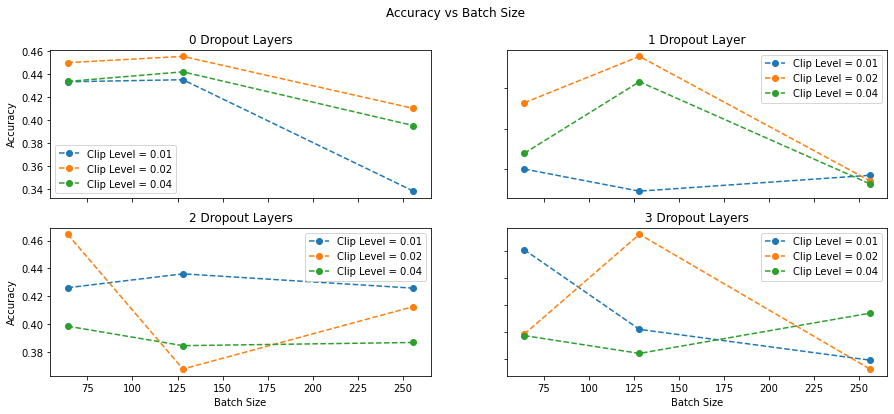

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15,6))
fig.suptitle('Accuracy vs Batch Size')
axs[0, 0].plot(data_drp0_clip1['batch_size'], data_drp0_clip1['accuracy'], 'o--', label = "Clip Level = 0.01")
axs[0, 0].plot(data_drp0_clip2['batch_size'], data_drp0_clip2['accuracy'], 'o--', label = "Clip Level = 0.02")
axs[0, 0].plot(data_drp0_clip4['batch_size'], data_drp0_clip4['accuracy'], 'o--', label = "Clip Level = 0.04")
axs[0, 0].set_title('0 Dropout Layers')
axs[0, 0].legend()

axs[0, 1].plot(data_drp1_clip1['batch_size'], data_drp1_clip1['accuracy'], 'o--', label = "Clip Level = 0.01")
axs[0, 1].plot(data_drp1_clip2['batch_size'], data_drp1_clip2['accuracy'], 'o--', label = "Clip Level = 0.02")
axs[0, 1].plot(data_drp1_clip4['batch_size'], data_drp1_clip4['accuracy'], 'o--', label = "Clip Level = 0.04")
axs[0, 1].set_title('1 Dropout Layer')
axs[0, 1].legend()

axs[1, 0].plot(data_drp2_clip1['batch_size'], data_drp2_clip1['accuracy'], 'o--', label = "Clip Level = 0.01")
axs[1, 0].plot(data_drp2_clip2['batch_size'], data_drp2_clip2['accuracy'], 'o--', label = "Clip Level = 0.02")
axs[1, 0].plot(data_drp2_clip4['batch_size'], data_drp2_clip4['accuracy'], 'o--', label = "Clip Level = 0.04")
axs[1, 0].set_title('2 Dropout Layers')
axs[1, 0].legend()

axs[1, 1].plot(data_drp3_clip1['batch_size'], data_drp3_clip1['accuracy'], 'o--', label = "Clip Level = 0.01")
axs[1, 1].plot(data_drp3_clip2['batch_size'], data_drp3_clip2['accuracy'], 'o--', label = "Clip Level = 0.02")
axs[1, 1].plot(data_drp3_clip4['batch_size'], data_drp3_clip4['accuracy'], 'o--', label = "Clip Level = 0.04")
axs[1, 1].set_title('3 Dropout Layers')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Batch Size', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('acc_batchsize.png')

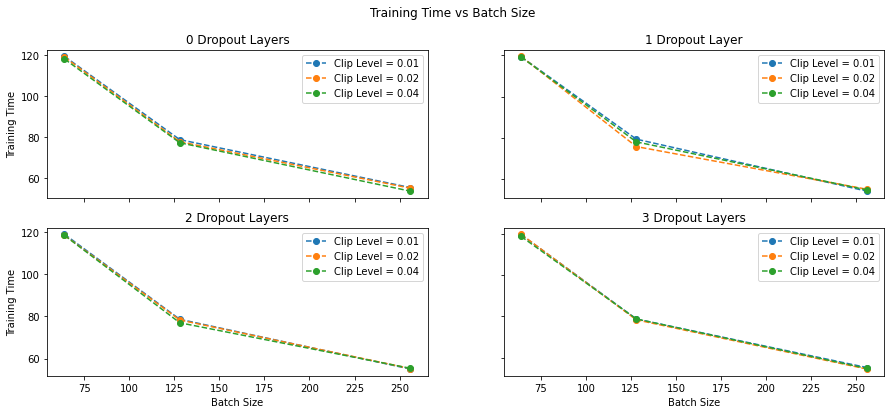

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15,6))
fig.suptitle('Training Time vs Batch Size')
axs[0, 0].plot(data_drp0_clip1['batch_size'], data_drp0_clip1['traintime'], 'o--', label = "Clip Level = 0.01")
axs[0, 0].plot(data_drp0_clip2['batch_size'], data_drp0_clip2['traintime'], 'o--', label = "Clip Level = 0.02")
axs[0, 0].plot(data_drp0_clip4['batch_size'], data_drp0_clip4['traintime'], 'o--', label = "Clip Level = 0.04")
axs[0, 0].set_title('0 Dropout Layers')
axs[0, 0].legend()

axs[0, 1].plot(data_drp1_clip1['batch_size'], data_drp1_clip1['traintime'], 'o--', label = "Clip Level = 0.01")
axs[0, 1].plot(data_drp1_clip2['batch_size'], data_drp1_clip2['traintime'], 'o--', label = "Clip Level = 0.02")
axs[0, 1].plot(data_drp1_clip4['batch_size'], data_drp1_clip4['traintime'], 'o--', label = "Clip Level = 0.04")
axs[0, 1].set_title('1 Dropout Layer')
axs[0, 1].legend()

axs[1, 0].plot(data_drp2_clip1['batch_size'], data_drp2_clip1['traintime'], 'o--', label = "Clip Level = 0.01")
axs[1, 0].plot(data_drp2_clip2['batch_size'], data_drp2_clip2['traintime'], 'o--', label = "Clip Level = 0.02")
axs[1, 0].plot(data_drp2_clip4['batch_size'], data_drp2_clip4['traintime'], 'o--', label = "Clip Level = 0.04")
axs[1, 0].set_title('2 Dropout Layers')
axs[1, 0].legend()

axs[1, 1].plot(data_drp3_clip1['batch_size'], data_drp3_clip1['traintime'], 'o--', label = "Clip Level = 0.01")
axs[1, 1].plot(data_drp3_clip2['batch_size'], data_drp3_clip2['traintime'], 'o--', label = "Clip Level = 0.02")
axs[1, 1].plot(data_drp3_clip4['batch_size'], data_drp3_clip4['traintime'], 'o--', label = "Clip Level = 0.04")
axs[1, 1].set_title('3 Dropout Layers')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Batch Size', ylabel='Training Time')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('tt_batchsize.png')

### Clip Level (Threshold) Analysis

In [19]:
data_drp1_batch64 = data_drp1.loc[data_drp1['batch_size']==64]
data_drp1_batch128 = data_drp1.loc[data_drp1['batch_size']==128]
data_drp1_batch256 = data_drp1.loc[data_drp1['batch_size']==256]

data_drp2_batch64 = data_drp2.loc[data_drp2['batch_size']==64]
data_drp2_batch128 = data_drp2.loc[data_drp2['batch_size']==128]
data_drp2_batch256 = data_drp2.loc[data_drp2['batch_size']==256]

data_drp3_batch64 = data_drp3.loc[data_drp3['batch_size']==64]
data_drp3_batch128 = data_drp3.loc[data_drp3['batch_size']==128]
data_drp3_batch256 = data_drp3.loc[data_drp3['batch_size']==256]

data_drp0_batch64 = data_drp0.loc[data_drp0['batch_size']==64]
data_drp0_batch128 = data_drp0.loc[data_drp0['batch_size']==128]
data_drp0_batch256 = data_drp0.loc[data_drp0['batch_size']==256]

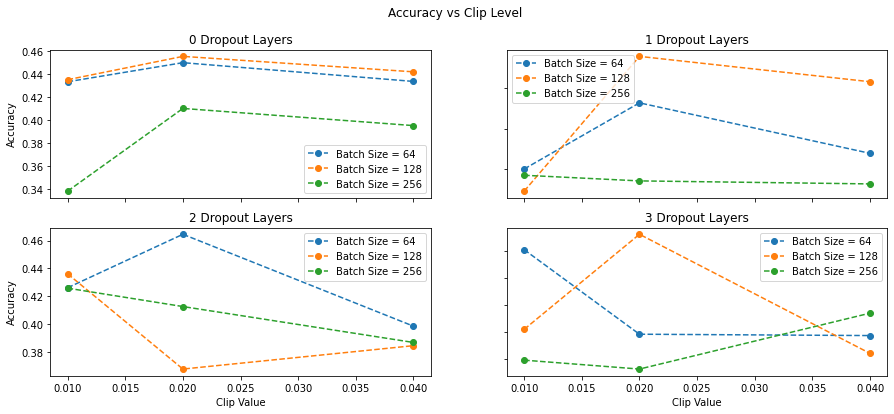

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15,6))
fig.suptitle('Accuracy vs Clip Level')
axs[0, 0].plot(data_drp0_batch64['clip'], data_drp0_batch64['accuracy'], 'o--', label = "Batch Size = 64")
axs[0, 0].plot(data_drp0_batch128['clip'], data_drp0_batch128['accuracy'], 'o--', label = "Batch Size = 128")
axs[0, 0].plot(data_drp0_batch256['clip'], data_drp0_batch256['accuracy'], 'o--', label = "Batch Size = 256")
axs[0, 0].set_title('0 Dropout Layers')
axs[0, 0].legend()

axs[0, 1].plot(data_drp1_batch64['clip'], data_drp1_batch64['accuracy'], 'o--', label = "Batch Size = 64")
axs[0, 1].plot(data_drp1_batch128['clip'], data_drp1_batch128['accuracy'], 'o--', label = "Batch Size = 128")
axs[0, 1].plot(data_drp1_batch256['clip'], data_drp1_batch256['accuracy'], 'o--', label = "Batch Size = 256")
axs[0, 1].set_title('1 Dropout Layers')
axs[0, 1].legend()

axs[1, 0].plot(data_drp2_batch64['clip'], data_drp2_batch64['accuracy'], 'o--', label = "Batch Size = 64")
axs[1, 0].plot(data_drp2_batch128['clip'], data_drp2_batch128['accuracy'], 'o--', label = "Batch Size = 128")
axs[1, 0].plot(data_drp2_batch256['clip'], data_drp2_batch256['accuracy'], 'o--', label = "Batch Size = 256")
axs[1, 0].set_title('2 Dropout Layers')
axs[1, 0].legend()

axs[1, 1].plot(data_drp3_batch64['clip'], data_drp3_batch64['accuracy'], 'o--', label = "Batch Size = 64")
axs[1, 1].plot(data_drp3_batch128['clip'], data_drp3_batch128['accuracy'], 'o--', label = "Batch Size = 128")
axs[1, 1].plot(data_drp3_batch256['clip'], data_drp3_batch256['accuracy'], 'o--', label = "Batch Size = 256")
axs[1, 1].set_title('3 Dropout Layers')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Clip Value', ylabel='Accuracy')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('acc_clipval.png')

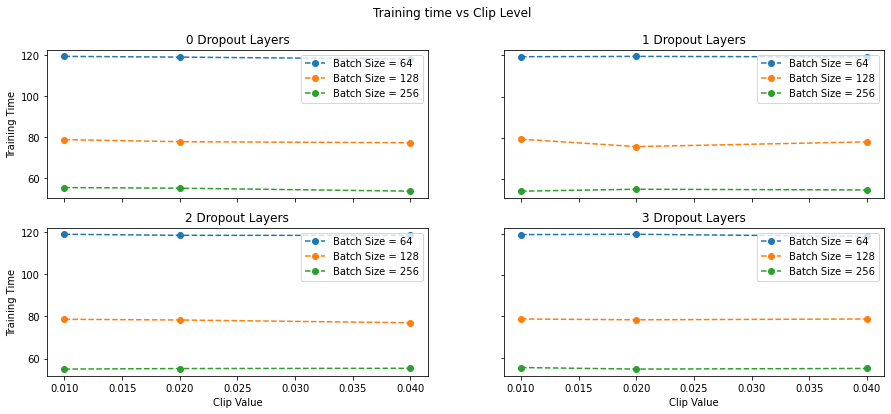

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15,6))
fig.suptitle('Training time vs Clip Level')
axs[0, 0].plot(data_drp0_batch64['clip'], data_drp0_batch64['traintime'], 'o--', label = "Batch Size = 64")
axs[0, 0].plot(data_drp0_batch128['clip'], data_drp0_batch128['traintime'], 'o--', label = "Batch Size = 128")
axs[0, 0].plot(data_drp0_batch256['clip'], data_drp0_batch256['traintime'], 'o--', label = "Batch Size = 256")
axs[0, 0].set_title('0 Dropout Layers')
axs[0, 0].legend()

axs[0, 1].plot(data_drp1_batch64['clip'], data_drp1_batch64['traintime'], 'o--', label = "Batch Size = 64")
axs[0, 1].plot(data_drp1_batch128['clip'], data_drp1_batch128['traintime'], 'o--', label = "Batch Size = 128")
axs[0, 1].plot(data_drp1_batch256['clip'], data_drp1_batch256['traintime'], 'o--', label = "Batch Size = 256")
axs[0, 1].set_title('1 Dropout Layers')
axs[0, 1].legend()

axs[1, 0].plot(data_drp2_batch64['clip'], data_drp2_batch64['traintime'], 'o--', label = "Batch Size = 64")
axs[1, 0].plot(data_drp2_batch128['clip'], data_drp2_batch128['traintime'], 'o--', label = "Batch Size = 128")
axs[1, 0].plot(data_drp2_batch256['clip'], data_drp2_batch256['traintime'], 'o--', label = "Batch Size = 256")
axs[1, 0].set_title('2 Dropout Layers')
axs[1, 0].legend()

axs[1, 1].plot(data_drp3_batch64['clip'], data_drp3_batch64['traintime'], 'o--', label = "Batch Size = 64")
axs[1, 1].plot(data_drp3_batch128['clip'], data_drp3_batch128['traintime'], 'o--', label = "Batch Size = 128")
axs[1, 1].plot(data_drp3_batch256['clip'], data_drp3_batch256['traintime'], 'o--', label = "Batch Size = 256")
axs[1, 1].set_title('3 Dropout Layers')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Clip Value', ylabel='Training Time')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('tt_clipval.png')

### Observations

1. Training time: Not much of a variation of training time with change in clip value, but the training time decreases when batch size is increased.

2. Accuracy: The accuracy after 1 epoch doesnt have a consistent trend across a varying number of dropout layers. That being said, for higher number of dropout layers, accuracy seems to improve with increasing batch size, and for a lower number of dropout layers, it decreases slightly. 

These observations are in line with that of the paper. Moreover, the paper suggests using higher batch sizes to emulate the behaviour of Batch Normalization layers. Similarly, they state that although the effects of clip value may not be visible in a few epochs, it helps to stabilize models with higher batch size.

Due to the constraint in processing time for this project, we have decided to follow the results of this ablation study as well as the authors recommendation in or analysis. Consequently, we use a higher batch size of 256 in order to speed up the training process and compare with batch normalization. In order ot stabilize the model, we use a small clip value of 0.02.
